In [1]:
import numpy as np
import cv2

from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt

# board detector
import detector

Using TensorFlow backend.


In [2]:
d = detector.Detector(64, 64, 'weights-02-0.43.hdf5')

model created with # params: 507858
loading model weights from path: weights-02-0.43.hdf5
loaded weights


In [3]:
def winner(state):
    state = np.reshape(state, [3,3])
    ones = np.ones(3)
    
    # check horizontal wins
    h = np.dot(ones, state)
    
    if np.any(h == 3):
        return 1
    elif np.any(h == -3):
        return -1
    
    # check vertical wins
    v = np.dot(state, ones)
    
    if np.any(v == 3):
        return 1
    elif np.any(v == -3):
        return -1
    
    # check diags
    dsum = np.sum(np.diag(state))
    if dsum == 3:
        return 1
    elif dsum == -3:
        return -1
    
    dsum = np.sum(np.diag(np.flipud(state)))
    if dsum == 3:
        return 1
    elif dsum == -3:
        return -1
    
    return 0

def draw(state):
    return not np.any(state==0)

def random_move(state):
    return np.random.choice(np.argwhere(state==0).flatten())

def random_game():
    state = np.zeros(9)
    states = [state.copy()]
    player = 1;
    while True:
        ri = random_move(state)
        state[ri] = player
        
        states.append(state.copy())
        
        w = winner(state)
        if w != 0:
            #print("winner")
            return w, states
        if draw(state):
            #print("draw")
            return 0, states
            
        player *= -1
        
def state_ones(state):
    z = np.zeros(18)
    for i, s in enumerate(state):
        if s == 1:
            z[i] = 1
        elif s == -1:
            z[i+9] = 1
    return z

def ones_state(ones):
    z = np.zeros(9)
    for i, s in enumerate(ones):
        if s == 1:
            if i < 9:
                z[i] = 1
            else:
                z[i-9] = -1
    return z

k = {0: "- ", -1: "O ", 1: "X "}
def vis(state):
    s = ""
    for i in range(9):
        if i%3 == 0:
            s += "\n"
        s += k[state[i]]
        
    print(s)


- - X 
- - X 
O O X 


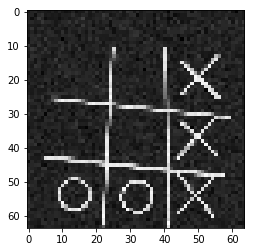

In [4]:
# data generation
gen_img_rows, gen_img_cols = 512, 512
low_rot = 4

def x_r():
    return np.random.randint(-10,10)

def rand_small_rot(img, sx, sy, s):
    rotation_matrix = cv2.getRotationMatrix2D((int(sx+s/2), int(sy+s/2)), np.random.randint(-low_rot,low_rot+1), 1)
    img = cv2.warpAffine(img, rotation_matrix, (gen_img_rows, gen_img_cols))
    return img

def img_from_state(state):
    
    img = np.zeros([gen_img_rows, gen_img_cols])
    s = 400 + np.random.randint(100)
    sx = np.random.randint(gen_img_cols-s)
    sy = np.random.randint(gen_img_rows-s)
    
    lw_lb = 6
    lw_ub = 8
    
    s_3 = int(s/3)
    s_x = int(s/24) + np.random.randint(30)
    s_o = int(s/24) + np.random.randint(20)
    
    # box
    #cv2.rectangle(img, (sx, sy), (sx+s, sy+s), 1, 1)

    # horizontal
    img = cv2.line(img, (sx, sy+s_3), (sx + s, sy+s_3), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    img = cv2.line(img, (sx, sy+s_3*2), (sx + s, sy+s_3*2), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    # vertical
    img = cv2.line(img, (sx+s_3, sy), (sx+s_3, sy+s), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    img = cv2.line(img, (sx+s_3*2, sy), (sx+s_3*2, sy+s), 1, np.random.randint(lw_lb, lw_ub))
    img = rand_small_rot(img, sx, sy, s)
    
    for i, s in enumerate(state):
        r = np.floor(i/3)
        c = i%3
        x = int(s_3/2 + sx + c * s_3)
        y = int(s_3/2 + sy + r * s_3)
        if s == 1:
            # draw x
            img = cv2.line(img, (x-s_x+x_r(), y-s_x+x_r()), (x+s_x+x_r(), y+s_x+x_r()), 1, np.random.randint(lw_lb, lw_ub))
            img = cv2.line(img, (x+s_x+x_r(), y-s_x+x_r()), (x-s_x+x_r(), y+s_x+x_r()), 1, np.random.randint(lw_lb, lw_ub))
            pass
        elif s == -1:
            #draw o
            img = cv2.circle(img, (x+x_r(), y+x_r()), s_o, 1, np.random.randint(lw_lb, lw_ub))
            pass
    
    img = cv2.resize(img, (64, 64))
    img += np.random.randn(64,64) * .05
    return img

w, states = random_game()
vis(states[-1])
plt.imshow(img_from_state(states[-1]), cmap=plt.cm.gray)

i: 0

- - - 
O - X 
X O - 


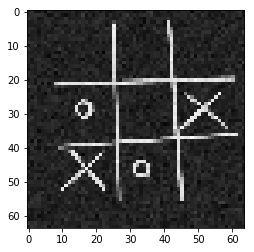

In [5]:
# make some training data
x_train = []
y_train = []

for i in range(100):
    if i % 1000 == 0:
        print('i: {}'.format(i))
    w, ss = random_game()
    s = ss[np.random.randint(len(ss))]
    img = img_from_state(s)
    
    x_train.append(img)
    y_train.append(state_ones(s))
    
x_train = np.array(x_train)
y_train = np.array(y_train)
    
plt.imshow(x_train[4], cmap=plt.cm.gray)
vis(ones_state(y_train[4]))

input_shape = None
img_rows = x_train.shape[1]
img_cols = x_train.shape[2]
num_outputs = y_train.shape[1]

In [ ]:
# train

d.model.fit(x_train, y_train, epochs=3, validation_split=.1, callbacks=[checkpointer])

pred

X X X 
X O O 
X O O 


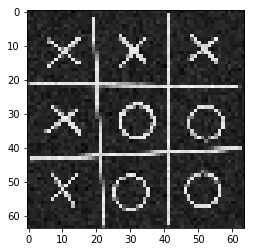

In [5]:
w, states = random_game()
img = img_from_state(states[-1])

fig = plt.imshow(img, cmap=plt.cm.gray)

print('pred')
pred = d.predict(img)
pred = np.round(pred)
vis(ones_state(pred))

array([ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0., -1.])

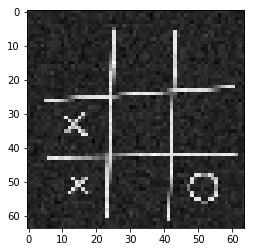

In [6]:
# take multiple samples to get the best identification
imgs = [img_from_state([0,0,0,1,0,0,1,0,-1]) for _ in range(10)]
plt.imshow(imgs[-1], cmap=plt.cm.gray)

pred = d.predict_average(imgs)
ones_state(pred)

In [9]:
# realtime board detection

def run_camera():
    cam = cv2.VideoCapture(1)
    k = 10
    last_k = []
    
    while True:
        ret_val, img = cam.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4)))
        
        img = cv2.flip(img, 1)
        img = img[0:d.img_rows, 0:d.img_cols]
        
        
        # adaptive thresholding
        # http://docs.opencv.org/trunk/d7/d4d/tutorial_py_thresholding.html
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 101, 15)
        img = 255-img
        img = img.astype(np.float64)
        img /= 255
        
        clear_output(wait=True)
        last_k.append(img)
        
        if len(last_k) >= k:
            print('pred: ')
            vis(ones_state(np.round(d.predict_average(last_k))))
            last_k = last_k[1:]
        
        cv2.imshow('board_detector', cv2.resize(img, (512, 512)))
        
        if cv2.waitKey(1) == 27:
            break  # esc to quit
            
            
    cv2.destroyAllWindows()

run_camera()

pred: 


KeyboardInterrupt: 